In [1]:
%cd drive/My\ Drive

/content/drive/My Drive


In [2]:
%cd case\ studies\ 2

/content/drive/My Drive/case studies 2


In [3]:
%cd Models/

/content/drive/My Drive/case studies 2/Models


In [4]:
%cd Voice\ Models

/content/drive/My Drive/case studies 2/Models/Voice Models


In [5]:
%cd MFCC/

/content/drive/My Drive/case studies 2/Models/Voice Models/MFCC


In [49]:
!ls

test_data.npy  test_label.npy  train_data.npy  train_label.npy


In [7]:
import pandas as pd
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten, BatchNormalization, Activation
from keras.models import Model
from keras import backend as K
from keras.utils.np_utils import to_categorical

from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
train_data = np.load('train_data.npy', allow_pickle=True)
train_labels = np.load('train_label.npy', allow_pickle = True)
test_data = np.load('test_data.npy', allow_pickle = True)
test_labels = np.load('test_label.npy', allow_pickle = True)

In [0]:
train_df = pd.DataFrame(columns = ['train_labels'])
train_df['train_labels'] = train_labels

In [0]:
test_df = pd.DataFrame(columns = ['test_labels'])
test_df['test_labels'] = test_labels

In [0]:
X = train_data
X_test = test_data

In [0]:
y = train_labels

In [0]:
y_test = test_labels

In [0]:
X_train = X[:6400]
X_val = X[6400:]
y_train = y[:6400]
y_val = y[6400:]

In [0]:
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_val = to_categorical(lb.fit_transform(y_val))
y_test = to_categorical(lb.fit_transform(y_test))

In [58]:
y_train.shape

(6400, 100)

In [59]:
y_val.shape

(1600, 100)

In [60]:
y_test.shape

(2000, 100)

In [0]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

In [62]:
input = Input(shape = (40, ))
x = Dense(128, activation = 'relu')(input)
x = Dense(128, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
encoded = Dense(32, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(encoded)
x = Dense(64, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(40, activation = 'softmax')(x)

In [63]:
autoencoder = Model(input, x)
autoencoder.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

In [64]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               5248      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112

In [0]:
filepath = 'voice_autoencoder.h5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
callbacks_list = [checkpoint]

In [68]:
autoencoder_train = autoencoder.fit(X_train, X_train, epochs = 100, batch_size = 16, verbose = 1, callbacks = callbacks_list, validation_data = [X_val, X_val])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 6400 samples, validate on 1600 samples
Epoch 1/100





6400/6400 [==============================] - 12s 2ms/step - loss: -125.6289 - acc: 0.0712 - val_loss: -147.2751 - val_acc: 0.0956

Epoch 00001: val_acc improved from -inf to 0.09563, saving model to voice_autoencoder.h5
Epoch 2/100
6400/6400 [==============================] - 3s 529us/step - loss: -147.7682 - acc: 0.1113 - val_loss: -155.3511 - val_acc: 0.1425

Epoch 00002: val_acc improved from 0.09563 to 0.14250, saving model to voice_autoencoder.h5
Epoch 3/100
6400/6400 [==============================] - 3s 528us/step - loss: -154.4807 - acc: 0.1280 - val_loss: -160.1229 - val_acc: 0.1344

Epoch 00003: val_acc did not improve from 0.14250
Epoch 4/100
6400/6400 [==============================] - 3s 537us/step - loss: -159.2281 - acc: 0.1531 - val_loss: -165.9257 - val_acc: 0.1638

Epoch 00004: val_acc improved from 0.14250 t

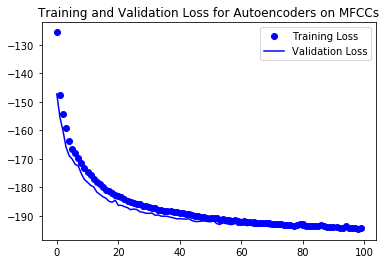

In [70]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(100)
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss for Autoencoders on MFCCs')
plt.legend()
plt.show()

In [0]:
autoencoder.save_weights('Autoencoder_Voices_Weights.h5')

In [0]:
input = Input(shape = (40, ))
x = Dense(128, activation = 'relu')(input)
x = Dense(128, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
encoded = Dense(32, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(encoded)
output = Dense(100, activation = 'softmax')(x)

In [0]:
full_model = Model(input, output)

In [74]:
len(full_model.layers)

8

In [0]:
for l1, l2 in zip(full_model.layers[:6], autoencoder.layers[0:6]):
  l1.set_weights(l2.get_weights())

In [76]:
autoencoder.get_weights()[0][1]

array([ 0.05387349, -0.10567961,  0.19412678,  0.17528418,  0.25584242,
       -0.15974623,  0.3653098 , -0.66731364, -0.21035647, -0.16649148,
       -0.0692225 , -0.040491  ,  0.19600216, -0.35123584, -0.5212695 ,
       -0.45420045, -0.05359562,  0.22080202,  0.11263556,  0.11165377,
        0.1522395 ,  0.74657553,  0.20379923,  0.1711179 , -0.14913252,
        0.05878667, -0.30182847, -0.14830917,  0.2060685 ,  0.17622708,
        0.19013682, -0.10642849,  0.06285158, -0.48234412, -0.04240697,
        0.22406282,  0.03625853, -0.22430946, -0.27700734, -0.06248192,
       -0.03643917, -0.37369007,  0.12959088, -0.00550769,  0.4069404 ,
       -0.76144636,  0.14754324,  0.06707559, -0.273207  ,  0.22935112,
        0.13974652, -0.01262413, -0.07659116,  0.03220008, -0.35661426,
       -0.31055135,  0.00755485,  0.07798854, -0.24147794, -0.18338472,
        0.1364172 , -0.0562776 ,  0.14168973, -0.13718778,  0.13327935,
       -0.32742736, -0.06032571, -0.06628612,  0.0475603 , -0.19

In [77]:
full_model.get_weights()[0][1]

array([ 0.05387349, -0.10567961,  0.19412678,  0.17528418,  0.25584242,
       -0.15974623,  0.3653098 , -0.66731364, -0.21035647, -0.16649148,
       -0.0692225 , -0.040491  ,  0.19600216, -0.35123584, -0.5212695 ,
       -0.45420045, -0.05359562,  0.22080202,  0.11263556,  0.11165377,
        0.1522395 ,  0.74657553,  0.20379923,  0.1711179 , -0.14913252,
        0.05878667, -0.30182847, -0.14830917,  0.2060685 ,  0.17622708,
        0.19013682, -0.10642849,  0.06285158, -0.48234412, -0.04240697,
        0.22406282,  0.03625853, -0.22430946, -0.27700734, -0.06248192,
       -0.03643917, -0.37369007,  0.12959088, -0.00550769,  0.4069404 ,
       -0.76144636,  0.14754324,  0.06707559, -0.273207  ,  0.22935112,
        0.13974652, -0.01262413, -0.07659116,  0.03220008, -0.35661426,
       -0.31055135,  0.00755485,  0.07798854, -0.24147794, -0.18338472,
        0.1364172 , -0.0562776 ,  0.14168973, -0.13718778,  0.13327935,
       -0.32742736, -0.06032571, -0.06628612,  0.0475603 , -0.19

In [0]:
for layer in full_model.layers[0:6]:
  layer.trainable = False

In [0]:
full_model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

In [80]:
full_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               5248      
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_16 (Dense)             (None, 128)               4224

In [81]:
filepath = 'pretrained_voice_best_weights.h5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
callbacks_list = [checkpoint]
pretrained_classifier_train = full_model.fit(X_train, y_train, epochs = 100, batch_size = 16, verbose = 1, callbacks = callbacks_list, validation_data = [X_val, y_val])

Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 2s 359us/step - loss: 1.8114 - acc: 0.6584 - val_loss: 0.6372 - val_acc: 0.8912

Epoch 00001: val_acc improved from -inf to 0.89125, saving model to pretrained_voice_best_weights.h5
Epoch 2/100
6400/6400 [==============================] - 2s 307us/step - loss: 0.4794 - acc: 0.9147 - val_loss: 0.4460 - val_acc: 0.9231

Epoch 00002: val_acc improved from 0.89125 to 0.92312, saving model to pretrained_voice_best_weights.h5
Epoch 3/100
6400/6400 [==============================] - 2s 308us/step - loss: 0.3415 - acc: 0.9381 - val_loss: 0.3611 - val_acc: 0.9369

Epoch 00003: val_acc improved from 0.92312 to 0.93688, saving model to pretrained_voice_best_weights.h5
Epoch 4/100
6400/6400 [==============================] - 2s 311us/step - loss: 0.2845 - acc: 0.9531 - val_loss: 0.3332 - val_acc: 0.9400

Epoch 00004: val_acc improved from 0.93688 to 0.94000, saving model to pretrained_voice_bes

In [0]:
full_model.save_weights('full_model_pretrained_voices_weights.h5')

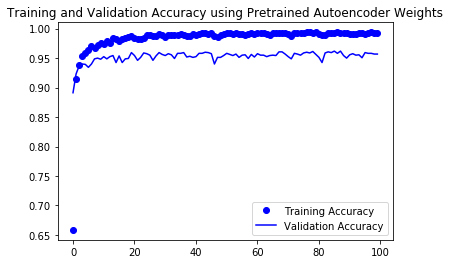

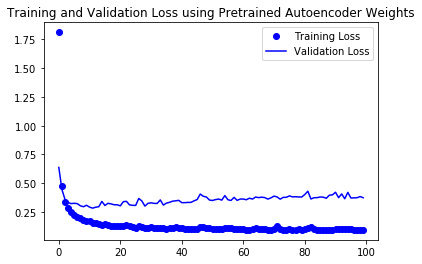

In [83]:
accuracy = pretrained_classifier_train.history['acc']
val_accuracy = pretrained_classifier_train.history['val_acc']
loss = pretrained_classifier_train.history['loss']
val_loss = pretrained_classifier_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy using Pretrained Autoencoder Weights')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss using Pretrained Autoencoder Weights')
plt.legend()
plt.show()

In [0]:
test_eval = full_model.evaluate(X_test, y_test, verbose = 0)

In [85]:
print('Test loss : ', test_eval[0])
print('Test accuracy : ', test_eval[1])

Test loss :  0.3654981872854987
Test accuracy :  0.959


In [0]:
predicted_classes = full_model.predict(X_test)

In [0]:
predicted_classes = np.argmax(np.round(predicted_classes), axis = 1)

In [0]:
predicted_classes = lb.inverse_transform(predicted_classes)

In [0]:
test_df['predicted_classes'] = predicted_classes

In [90]:
test_df.head()

,test_labels,predicted_classes
0,103,103
1,1624,1624
2,5163,5163
3,201,201
4,4160,4160


In [91]:
test_df[test_df['test_labels'] != test_df['predicted_classes']]

,test_labels,predicted_classes
6,7902,374
51,8797,5703
81,2182,4852
83,446,4323
86,89,4852
...,...,...
1903,2182,4852
1912,3112,6476
1924,446,61
1928,4515,6818


In [92]:
1-round(len(test_df[test_df['test_labels'] != test_df['predicted_classes']])/len(test_df),3)

0.957